In [2]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
############ EVALUATE HUB-HEIGHT HURRICANE STATISTICS RELEVANT FOR ############
#################### IEC STANDARD FOR ALL HURRICANES  #########################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [3]:
#%% Define file locations
## BLANCA
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"

## KESTREL
WRF_DIRECTORY = "/scratch/mgomez/Hurricane/idealized/test/sst_30_skipd01_skipCoLES_ndg/"

# Choose which domain to evaluate
domain = 'd02'

# Whether or not to save figures
saveFig = 'False'

# Time series output for each restart
restarts = '.' # timeSeries_d03


# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')
startTime_dom = np.datetime64('2000-01-06T10:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 3


In [4]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

# entries = ["auxHist24_d03_2000-01-06_12:25:30","auxHist24_d02_2000-01-06_12:35:30"]
# rndmFromInterest = 0

# entries = ["auxHist24_d02_2000-01-06_11:31:30"]
# rndmFromInterest = 0

print(entries[rndmFromInterest])


# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
w = ds['W']
w = np.array(w[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Time
Time_3d = ds['Times']
a = str(np.array(Time_3d)[0])
ttime_3d = np.datetime64(a[2:12] + str(' ')+ a[13:-1])
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])

# Save some memory
uv = uv[0:10,:,:]
w = w[0:10,:,:]

ds.close()


auxHist24_d02_2000-01-06_11:05:30


In [5]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 126 #240
z_hh = 90 #150
rated_ws = 11.4

print("Done extracting data from general variables")


Done extracting data from general variables


In [6]:
#%% Define use for each station
# Define number of "stations" for high-temporal resolution data 
if domain=='d05':
    which_stations = 'hi'
elif domain=='d04':
#     which_stations = 'lol'
    which_stations = 'd4'
elif domain=='d03':
    which_stations = 'd'
elif domain=='d02':
    which_stations = 'd3'

# Remove time series locations that are not going to be used in analysis
stations = []
for i in np.arange(len(name_locs)):
    if which_stations in name_locs[i]:
        stations = np.append(stations,i)
stations = stations.astype('int')
# stations = stations[:9]
# stations = stations[::9]
# stations = stations[18:63:2]
# stations = stations[85:100]
# stations = stations[18:11*9]
print(stations)
locs = locs[stations]
name_locs = name_locs[stations]
print(name_locs)

# Remove time series locations that are incorrect
if domain=='d05':
    stats = []
    for i in np.arange(len(name_locs)):
        if not locs[i,0] == locs[i,1]:
            stats = np.append(stats,i)       
    stats = stats.astype('int')
    print(stats)
    locs = locs[stats]
    name_locs = name_locs[stats]
    print(name_locs)

locs = locs.astype('int')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

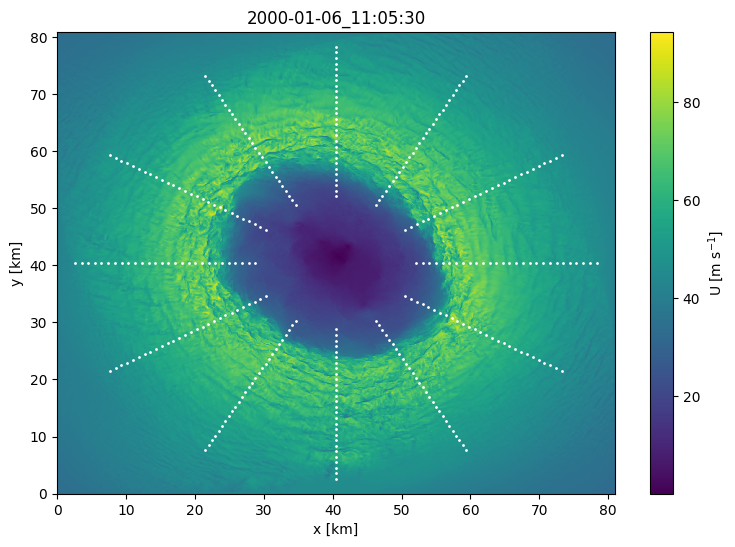

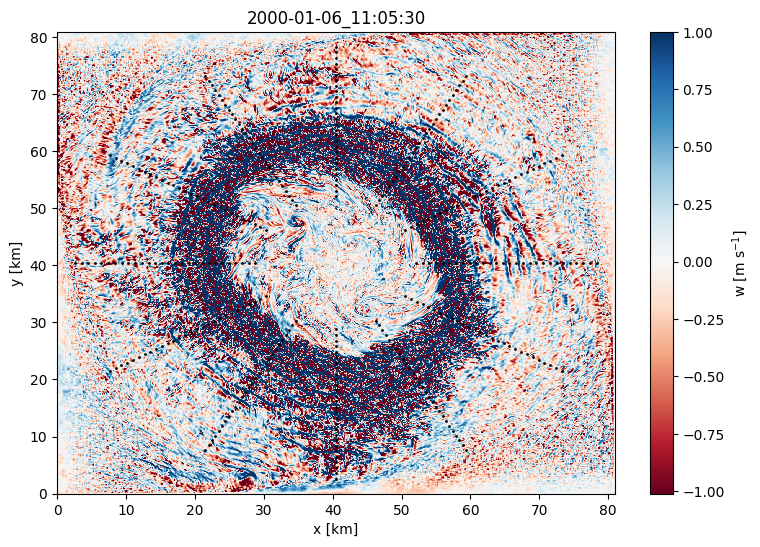

In [7]:
#%% Show relative locations of met tower in the domain
iz = 7

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
minn = -1.01 #np.min(w[iz,:,:])
maxx = 1.0 #np.max(w[iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w[iz,:,:],vmin=minn,vmax=maxx,cmap=newCmap)
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='black')
cbar = plt.colorbar(im1)
cbar.set_label("w [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


In [7]:
#%% Extract high-temporal resolution data
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.UU',skiprows=1)
temp = temp[0:-200,:]
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
#     tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
#     W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))

# Release memory
tempU = 0.0
tempV = 0.0
# tempW = 0.0

print("Done extracting high-temporal resolution data")


Done with 0 out of 251
Done with 1 out of 251
Done with 2 out of 251
Done with 3 out of 251
Done with 4 out of 251
Done with 5 out of 251
Done with 6 out of 251
Done with 7 out of 251
Done with 8 out of 251
Done with 9 out of 251
Done with 10 out of 251
Done with 11 out of 251
Done with 12 out of 251
Done with 13 out of 251
Done with 14 out of 251
Done with 15 out of 251
Done with 16 out of 251
Done with 17 out of 251
Done with 18 out of 251
Done with 19 out of 251
Done with 20 out of 251
Done with 21 out of 251
Done with 22 out of 251
Done with 23 out of 251
Done with 24 out of 251
Done with 25 out of 251
Done with 26 out of 251
Done with 27 out of 251
Done with 28 out of 251
Done with 29 out of 251
Done with 30 out of 251
Done with 31 out of 251
Done with 32 out of 251
Done with 33 out of 251
Done with 34 out of 251
Done with 35 out of 251
Done with 36 out of 251
Done with 37 out of 251
Done with 38 out of 251
Done with 39 out of 251
Done with 40 out of 251
Done with 41 out of 251
Do

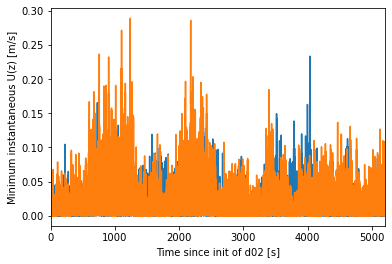

In [8]:
#%% Find virtual met-towers with wrong data

# Define wrong/corrupted conditions
u_vel = 0.0
v_vel = 0.0

# Find stations with wrong data
i_stat_wrong = np.zeros(np.shape(locs)[0])
for i_s in np.arange(np.shape(locs)[0]):
    # Compare wind fields at each station with wrong conditions
    wheres_u = np.where(U[i_s,:,:]==u_vel)[0]
    wheres_v = np.where(V[i_s,:,:]==v_vel)[0]
    if (len(wheres_u)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(U[i_s,:,iz]==u_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    U[i_s,ii_tt,iz] = U[i_s,ii_tt-1,iz]
#                 U[i_s,tmp_where[:],iz] = np.nan
    if (len(wheres_v)>0):
        i_stat_wrong[i_s] = 1
        for iz in np.arange(len(hgt_agl)):
            tmp_where = np.where(V[i_s,:,iz]==v_vel)[0]
            if (len(tmp_where)>0):
                for ii_tt in tmp_where:
                    V[i_s,ii_tt,iz] = V[i_s,ii_tt-1,iz]
#                 V[i_s,tmp_where[:],iz] = np.nan
i_stat_wrong = i_stat_wrong.astype('int')

# Fiugre showing time series
plt.figure()
# plt.plot(time_sinceRst,np.nanmin(UV[:,:,:],axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(U[:,:,:]),axis=(0,2)))
plt.plot(time_sinceRst,np.nanmin(np.abs(V[:,:,:]),axis=(0,2)))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Minimum instantaneous U(z) [m/s]')
plt.show()
plt.close()

In [9]:
#%% Calculate horizontal wind speed and wind direction using time series output
# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

# Calculate horizontal wind direction
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180

# Clear memory
U = 0.0
V = 0.0
uu = 0
vv = 0



In [10]:
#%% Load data for temporal evolution of hurricane center for each height
# if domain == 'd03':
#     center_x = np.array([61324.50802739,53372.36928984]) #np.zeros(len(time_sinceRst)) + 52785.38902399
#     center_y = np.array([67166.13973252,56137.35728448]) #np.zeros(len(time_sinceRst)) + 54261.34061233
#     time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0
    
#     center_x = np.array([np.mean(n_x),np.mean(n_x)])
#     center_y = np.array([np.mean(n_y),np.mean(n_y)])

center_x = np.array([np.mean(n_x),np.mean(n_x)]) #np.zeros(len(time_sinceRst)) + 52785.38902399
center_y = np.array([np.mean(n_y),np.mean(n_y)]) #np.zeros(len(time_sinceRst)) + 54261.34061233
time_center_sinceRst = np.array([time_sinceRst[0], time_sinceRst[-1]]) #time_sinceRst + 0.0
    
# arr_x = np.loadtxt(WRF_DIRECTORY + '/center_x.txt',skiprows=1,delimiter=',')
# arr_y = np.loadtxt(WRF_DIRECTORY + '/center_y.txt',skiprows=1,delimiter=',')

# time_center = arr_x[:,0]
# time_center_sinceRst = time_center - time_center[0]
# center_x = arr_x[:,1:]
# center_y = arr_y[:,1:]
    

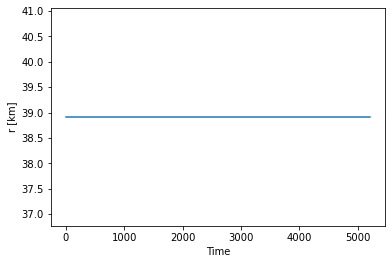

In [11]:
#%% Estimate temporal evolution of radial distance for each time series location at one height
radial_dist = np.zeros([len(time_center_sinceRst),np.shape(locs)[0]])
iz = 0

for it in np.arange(len(time_center_sinceRst)):
    if len(np.shape(center_x))==1:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it])**2 + (n_y[locs[:,1]] - center_y[it])**2)**0.5
    else:
        radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it,iz])**2 + (n_y[locs[:,1]] - center_y[it,iz])**2)**0.5

# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

# Radial locations (assuming hurricane does not move)
r_t0 = radial_dist[0,:]


Text(0, 0.5, 'r [km]')

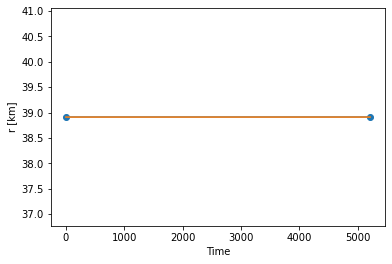

In [12]:
#%% Interpolate data in time to match time series output
# if domain=='d04':
#     # Interpolate center of hurricane at each height
#     center = np.zeros([len(time_sinceRst),np.shape(center_x)[1],2]) # [time, height, x or y center location]
#     for i_z in np.arange(np.shape(center_x)[1]):
#         center[:,i_z,0] = np.interp(time_sinceRst,time_center_sinceRst,center_x[:,i_z])
#         center[:,i_z,1] = np.interp(time_sinceRst,time_center_sinceRst,center_y[:,i_z])
    
# Interpolate radial distance from center of hurricane at z=10m
r_fromC = np.zeros([len(time_sinceRst),np.shape(locs)[0]]) # [time, station, radial distance]
for i_s in np.arange(np.shape(locs)[0]):
    r_fromC[:,i_s] = np.interp(time_sinceRst,time_center_sinceRst,radial_dist[:,i_s])
    
# Time series of radial distance for a given met-tower at one height
plt.figure()
plt.plot(time_center_sinceRst,radial_dist[:,-1]/1000,'-o')
plt.plot(time_sinceRst,r_fromC[:,-1]/1000)
plt.xlabel('Time')
plt.ylabel('r [km]')

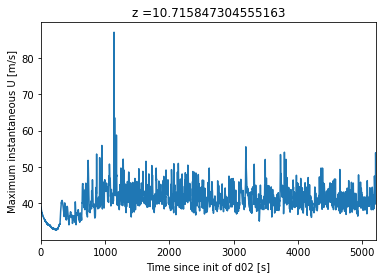

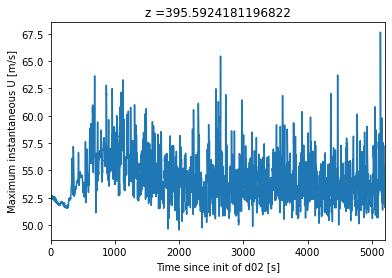

In [13]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
col = plt.cm.viridis(np.linspace(0,1,len(locs)))

# Surface
iz = 0
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()


# Boundary layer
iz = -1
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()

## Get moving average from hurricane

In [14]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [15]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])

print(dt)


0.18055597588858796


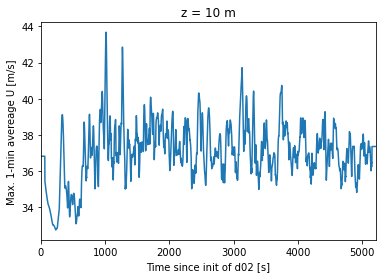

In [16]:
#%% Hurricane intensity
window_1m = 1*60 # [s]
n_window_1m = int(window_1m/dt)

avgUV_1m = np.zeros(np.shape(UV))
avgUV_1m = avgUV_1m[:,:,0]

for i_s in np.arange(np.shape(UV)[0]):
    avgUV_1m[i_s,:] = moving_average(UV[i_s,:,0],n_window_1m,'same')
    
# Mean intensity
mean_intensity = np.mean(np.max(np.abs(avgUV_1m),axis=0))

    
plt.figure()
plt.title('z = '+str(int(hgt_agl[0]))+" m")
# plt.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,np.max(np.abs(avgUV_1m),axis=0))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Max. 1-min avereage U [m/s]')
plt.show()
plt.close()



In [17]:
# Define eyewall radius based on 3D fields
if 'sst_26' in WRF_DIRECTORY:
    r_eye = 25000 #23361
    label = '26 C'
elif 'sst_28' in WRF_DIRECTORY:
    r_eye = 15138
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    r_eye = 20333
    label = '30 C'

print('Eyewall radius at r = %f km' % (r_eye/1000))


Eyewall radius at r = 25.000000 km


In [18]:
#%% Time window for mean and perturbation quantities
window_avg = 10*60 # [s]
n_window_avg= int(window_avg/dt)


In [19]:
#%% Chose heights for analysis
z_spctr = np.array([10,100,350])
i_z_spctr = np.zeros_like(z_spctr)
for i in np.arange(len(z_spctr)):
    i_z_spctr[i] = np.argmin(np.abs(hgt_agl-z_spctr[i]))
i_z_spctr = i_z_spctr.astype('int')


In [20]:
#%% Calculate average and perturbation quantities
# Initialize arrays
avgUV_spctr = np.zeros([np.shape(UV)[0],np.shape(UV)[1],len(i_z_spctr)])
pertUV_spctr = np.zeros([np.shape(UV)[0],np.shape(UV)[1],len(i_z_spctr)])

# Calcluate mean and perturbation quantities
for i_s in np.arange(np.shape(UV)[0]): # station
    for iz in np.arange(len(i_z_spctr)): # height
        avgUV_spctr[i_s,:,iz] = moving_average(UV[i_s,:,i_z_spctr[iz]],n_window_avg,'same')
        pertUV_spctr[i_s,:,iz] = UV[i_s,:,i_z_spctr[iz]] - avgUV_spctr[i_s,:,iz]
pertUV_spctr = signal.detrend(pertUV_spctr,axis=1)


In [21]:
#%% Calculate turbulence spectra for window_avg time windows
# Number of "window_avg" periods to estiamte turbulence spectra
n_window_spctr = int(1.1*n_window_avg)
num_batches = int(np.floor(np.shape(UV)[1]/n_window_spctr))

# Initialize arrays
ff,P_temp = signal.welch(pertUV_spctr[-1,0:n_window_spctr,-1], fs=1/dt,window='hanning',nperseg=n_window_avg,scaling='spectrum')
P_temp = 0.0
df = np.median(ff[1:] - ff[0:-1])
P_uv = np.zeros([np.shape(UV)[0],len(i_z_spctr),num_batches,len(ff)]) + np.nan

# Estimate spectra
for i_batch in np.arange(np.shape(P_uv)[2]): # Time window
    for i_s in np.arange(np.shape(UV)[0]): # station
        for iz in np.arange(len(i_z_spctr)): # height 
            ff,P_uv[i_s,iz,i_batch,:] = signal.welch(pertUV_spctr[i_s,int(i_batch*n_window_spctr):int((i_batch+1)*n_window_spctr),iz], fs=1/dt,window='hanning',nperseg=n_window_avg,scaling='density',average='mean')


In [22]:
np.shape(avgUV_spctr)

(252, 28867, 3)

In [23]:
#%% Average spectra for each common radial location
# Radial locations for analysis
rad_dist_spctr = np.arange(0.5,2,0.2)*r_eye

# Initialize array
P_uv_r = np.zeros([len(rad_dist_spctr)-1,len(i_z_spctr),num_batches,len(ff)])
UV_r = np.zeros([len(rad_dist_spctr)-1,len(i_z_spctr)])

# Avearge for each radial location
for ir in np.arange(len(rad_dist_spctr)-1):
    i_stats = np.where((r_t0>=rad_dist_spctr[ir]) & (r_t0<rad_dist_spctr[ir+1]))[0]
    P_uv_r[ir,:,:,:] = np.nanmedian(P_uv[i_stats,:,:,:],axis=0)
    UV_r[ir,:] = np.nanmean(avgUV_spctr[i_stats,:,:],axis=(0,1))

rad_dist_spctr = 0.5*(rad_dist_spctr[1:] + rad_dist_spctr[0:-1])
rad_dist_spctr = rad_dist_spctr[np.nansum(P_uv_r,axis=(1,2,3))>0]
UV_r = UV_r[np.nansum(P_uv_r,axis=(1,2,3))>0,:]
P_uv_r = P_uv_r[np.nansum(P_uv_r,axis=(1,2,3))>0,:,:,:]


/projects/misa5952/software/anaconda/envs/env_forWRF/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-23-7474fd4c318a>:13: RuntimeWarning: Mean of empty slice
  UV_r[ir,:] = np.nanmean(avgUV_spctr[i_stats,:,:],axis=(0,1))


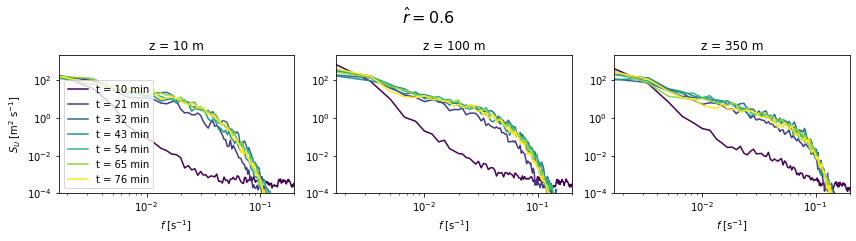

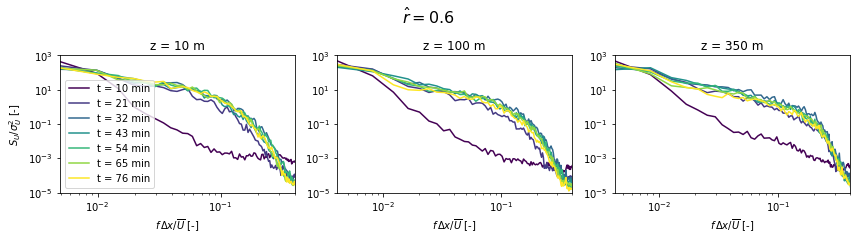

In [24]:
#%% Evaluate time required for spinup for one radial location
ir = 0

## Visualize spectra at all heights for one radial location in 10-min batches
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,num_batches))
for i_t in np.arange(num_batches): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        t_labl = n_window_spctr*dt*(i_t+1)/60 # n_window_spctr*dt*(i_t+0.5)/60
        axs[iz].loglog(ff,P_uv_r[ir,iz,i_t,:],color=cols[i_t],label='t = ' + str(int(t_labl))+" min")
        if i_t==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
#         axs[iz].set_xlim(ff[1],ff[-1])
#         axs[iz].set_ylim(1e-9,1e3)
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(1e-4,2e3)
axs[0].legend() #,bbox_to_anchor=(1, .102))
axs[0].set_ylabel(r'$S_{U}$ [m$^2$ s$^{-1}$]') # (m/s)^2 / (1/s) -> density || (m/s)^2 -> spectrum
fig.suptitle(r'$\hat{r} = $'+str(np.round(rad_dist_spctr[ir]/r_eye,2)),y=1.1,fontsize=16)
plt.tight_layout()
plt.show()

## Visualize normalized spectra at all heights for one radial location in 10-min batches
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,num_batches))
for i_t in np.arange(num_batches): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        t_labl = n_window_spctr*dt*(i_t+1)/60 # n_window_spctr*dt*(i_t+0.5)/60
        ff_norm = ff*dx/(UV_r[ir,iz])
        axs[iz].loglog(ff_norm,P_uv_r[ir,iz,i_t,:]/np.nansum(P_uv_r[ir,iz,i_t,:]*df),color=cols[i_t],label='t = ' + str(int(t_labl))+" min")
        if i_t==0:
            axs[iz].set_xlabel(r'$f\,\Delta x/\overline{U}$ [-]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
#         axs[iz].set_xlim(ff[1],ff[-1])
#         axs[iz].set_ylim(1e-8,1e3)
        axs[iz].set_xlim(ff_norm[1],4e-1)
        axs[iz].set_ylim(1e-5,1e3)
axs[0].legend()
axs[0].set_ylabel(r'$S_{U}/\sigma_U^2$ [-]') # (m/s)^2 / (1/s)
fig.suptitle(r'$\hat{r} = $'+str(np.round(rad_dist_spctr[ir]/r_eye,2)),y=1.1,fontsize=16)
plt.tight_layout()
plt.show()



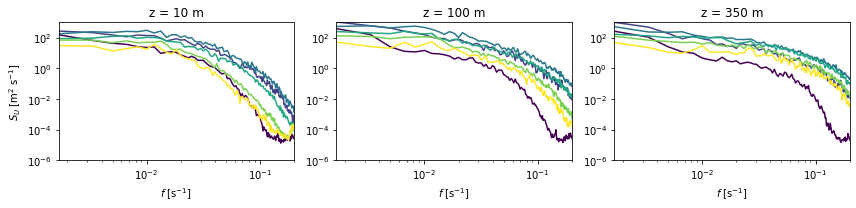

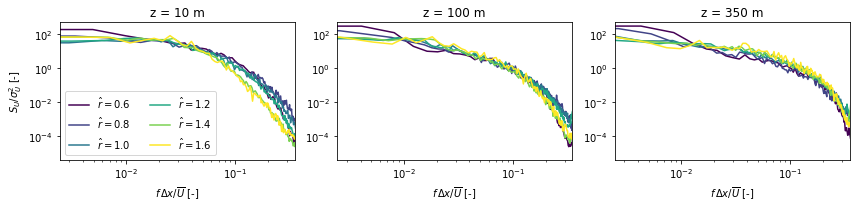

In [25]:
#%% Evaluate spatial extent required for spinup

i_t = -1

# Visualize spectra
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,len(rad_dist_spctr)))
for i_s in np.arange(len(rad_dist_spctr)): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        axs[iz].loglog(ff,P_uv_r[i_s,iz,i_t,:],color=cols[i_s],label=r'$\hat{r} = $'+str(np.round(rad_dist_spctr[i_s]/r_eye,2)))
        if i_s==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
        axs[iz].set_xlim(ff[1],ff[-1])
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(1e-6,1e3)
# axs[0].legend()
axs[0].set_ylabel(r'$S_{U}$ [m$^2$ s$^{-1}$]') # (m/s)^2 / (1/s) -> density || (m/s)^2 -> spectrum
plt.tight_layout()
plt.show()


# Visualize normalized spectra
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,len(rad_dist_spctr)))
for i_s in np.arange(len(rad_dist_spctr)): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        ff_norm = ff*dx/(UV_r[i_s,iz])
        axs[iz].loglog(ff_norm,P_uv_r[i_s,iz,i_t,:]/np.nansum(P_uv_r[i_s,iz,i_t,:]*df),color=cols[i_s],label=r'$\hat{r} = $'+str(np.round(rad_dist_spctr[i_s]/r_eye,2)))
        if i_s==0:
            axs[iz].set_xlabel(r'$f\,\Delta x/\overline{U}$ [-]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
        axs[iz].set_xlim(ff_norm[1],4e-1)
        axs[iz].set_ylim(4e-6,5e2)
axs[0].set_xlim(ff_norm[1],3.5e-1)
axs[1].set_xlim(ff_norm[1],3.5e-1)
axs[2].set_xlim(ff_norm[1],3.5e-1)
axs[0].legend(ncol=2) #,bbox_to_anchor=(1, .102))
axs[0].set_ylabel(r'$S_{U}/\sigma_U^2$ [-]') # (m/s)^2 / (1/s)
plt.tight_layout()
plt.show()



In [26]:
#%% Resolvable scales
k_res = (3.5e-1)/dx
print("Reolve up to %f m structures (%f DX)" % (1/k_res,1/k_res/dx))

Reolve up to 158.730283 m structures (2.857143 DX)
